In [1]:
from keras.models import load_model, Sequential
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("/content/gdrive/My Drive/Final_Folder")

In [0]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

In [0]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(784, activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=[28, 28, 1], name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

In [0]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [7]:
model = CapsNet(input_shape=[28, 28, 1],
                n_class=10,
                num_routing=3)
model.summary()
try:
    plot_model(model, to_file='model.png', show_shapes=True)
except Exception as e:
    print('No fancy plot {}'.format(e))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1152, 8)      0           conv2d_1

In [0]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

In [9]:
x_train.shape

(29400, 784)

In [0]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = to_categorical(y_train.astype('float32'))
y_test = to_categorical(y_test.astype('float32'))

In [0]:
def train(model, data, epoch_size_frac=1.0):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

    # compile the model
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics={'out_caps': 'accuracy'})

    
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint])
    

    model.save_weights('trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')

    return model

In [0]:
# train(model=model, data=((x_train, y_train), (x_test[:60], y_test[:60])), 
#       epoch_size_frac = 1.0) # do 10% of an epoch (takes too long)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
459/459 [==============================] - 112s 243ms/step - loss: 0.1374 - out_caps_loss: 0.1373 - out_recon_loss: 0.1284 - out_caps_acc: 0.8615 - val_loss: 0.0400 - val_out_caps_loss: 0.0400 - val_out_recon_loss: 0.0673 - val_out_caps_acc: 0.9667

Epoch 00001: val_loss improved from inf to 0.04002, saving model to weights-01.h5
Epoch 2/100
459/459 [==============================] - 104s 227ms/step - loss: 0.0378 - out_caps_loss: 0.0378 - out_recon_loss: 0.0613 - out_caps_acc: 0.9749 - val_loss: 0.0296 - val_out_caps_loss: 0.0296 - val_out_recon_loss: 0.0663 - val_out_caps_acc: 0.9667

Epoch 00002: val_loss improved from 0.04002 to 0.02964, saving model to weights-02.h5
Epoch 3/100
459/459 [==============================] - 103s 225ms/step - loss: 0.0278 - out_caps_loss: 0.0278 - out_recon_loss: 0.0608 - out_caps_acc: 0.9810 - val_loss: 0.0245 - val_out_caps_loss: 0.0245 - val_out_recon_loss: 0.0656 - val_out_caps_acc: 0.9667

In [0]:
# def combine_images(generated_images):
#     num = generated_images.shape[0]
#     width = int(np.sqrt(num))
#     height = int(np.ceil(float(num)/width))
#     shape = generated_images.shape[1:3]
#     image = np.zeros((height*shape[0], width*shape[1]),
#                      dtype=generated_images.dtype)
#     for index, img in enumerate(generated_images):
#         i = int(index/width)
#         j = index % width
#         image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
#             img[:, :, 0]
#     return image

# def test(model, data):
#     x_test, y_test = data
#     y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
#     print('-'*50)
#     print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

#     import matplotlib.pyplot as plt
#     from PIL import Image

#     img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
#     image = img * 255
#     Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
#     print()
#     print('Reconstructed images are saved to ./real_and_recon.png')
#     print('-'*50)
#     plt.imshow(plt.imread("real_and_recon.png", ))
#     plt.show()

--------------------------------------------------
Test acc: 1.0

Reconstructed images are saved to ./real_and_recon.png
--------------------------------------------------


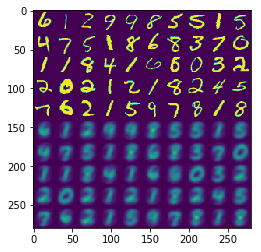

In [0]:
# test(model=model, data=(x_test[:100], y_test[:100]))

# Testing on unmanipulated images

In [0]:
model.load_weights("./Weights/CapsNet_MNIST.h5")

In [0]:
images = np.load('./Test_Data/MNIST/Rotated/listOfImages.npy')

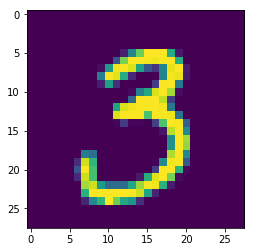

In [15]:
from matplotlib import pyplot as plt
plt.imshow(images[90])

In [0]:
image1 = images[90].reshape(-1, 28, 28, 1)

In [0]:
image1_pred = np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [0]:
y_pred, x_recon = model.predict([image1, image1_pred])

In [20]:
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.0042125  0.03256769 0.05899103 0.9651569  0.01339312 0.01559564
  0.00718941 0.01160945 0.00490061 0.01776057]] 
 Number is  3


# Testing on rotated images

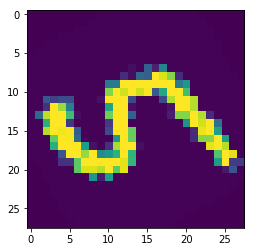

In [21]:
from matplotlib import pyplot as plt
plt.imshow(images[5451])

In [0]:
image2 = images[5451].reshape(-1, 28, 28, 1)

In [0]:
image2_pred = np.array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [0]:
y_pred, x_recon = model.predict([image2, image2_pred])

In [25]:
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.06829742 0.02007056 0.01388261 0.00727306 0.01415211 0.4356101
  0.14111553 0.03218554 0.07119843 0.10737319]] 
 Number is  5


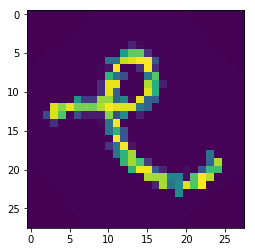

In [26]:
from matplotlib import pyplot as plt
plt.imshow(images[47])

In [0]:
image3 = images[47].reshape(-1, 28, 28, 1)

In [0]:
image3_pred = np.array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [0]:
y_pred, x_recon = model.predict([image3, image3_pred])

In [30]:
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.01198048 0.12452617 0.5228888  0.05100372 0.00466789 0.00180918
  0.01304086 0.01227845 0.2581647  0.26007897]] 
 Number is  2


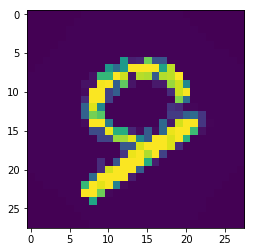

In [31]:
from matplotlib import pyplot as plt
plt.imshow(images[16])

In [0]:
image3 = images[16].reshape(-1, 28, 28, 1)

In [0]:
image3_pred = np.array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [0]:
y_pred, x_recon = model.predict([image3, image3_pred])

In [35]:
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.0471475  0.01783025 0.03202121 0.00275059 0.0144952  0.01420641
  0.00309055 0.00791197 0.3477928  0.6249029 ]] 
 Number is  9


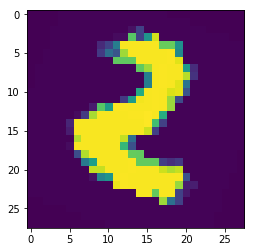

In [36]:
from matplotlib import pyplot as plt
plt.imshow(images[8495])

In [0]:
image4 = images[8495].reshape(-1, 28, 28, 1)

In [0]:
image4_pred = np.array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [0]:
y_pred, x_recon = model.predict([image4, image4_pred])

In [40]:
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.07562532 0.06310862 0.92762595 0.03978106 0.06043769 0.00918665
  0.07968998 0.03306314 0.05937652 0.0376988 ]] 
 Number is  2


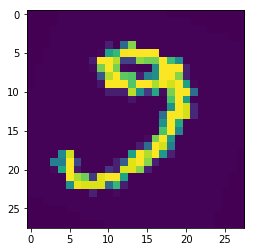

In [41]:
from matplotlib import pyplot as plt
plt.imshow(images[98])

In [0]:
image5 = images[98].reshape(-1, 28, 28, 1)

In [0]:
image5_pred = np.array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [0]:
y_pred, x_recon = model.predict([image5, image5_pred])

In [45]:
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.05754919 0.03156137 0.0079925  0.02673436 0.02920408 0.00328482
  0.00945889 0.03045316 0.00515349 0.7369427 ]] 
 Number is  9


# Testing on Translated Images

In [0]:
image_trans1 = np.load('./Test_Data/MNIST/Translated/test_4_transform.npy')

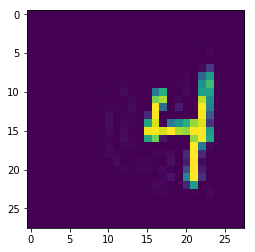

In [47]:
from matplotlib import pyplot as plt
plt.imshow(image_trans1)

In [0]:
img1 = image_trans1.reshape(-1, 28, 28, 1)

In [0]:
yolo_pred = np.array([[0,0,0,0,0,0,0,0,0,0]])

In [0]:
y_pred, x_recon = model.predict([img1, yolo_pred])

In [51]:
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.0254028  0.12028997 0.04511073 0.00782302 0.79831594 0.11568999
  0.12581389 0.06214181 0.01107064 0.03144235]] 
 Number is  4


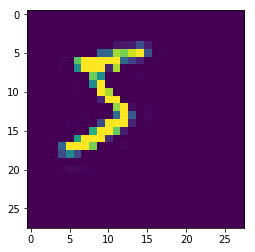

In [52]:
image_trans2 = np.load('./Test_Data/MNIST/Translated/test_5_transform.npy')
from matplotlib import pyplot as plt
plt.imshow(image_trans2)
img2 = image_trans2.reshape(-1, 28, 28, 1)
yolo_pred = np.array([[0,0,0,0,0,0,0,0,0,0]])

In [53]:
y_pred, x_recon = model.predict([img2, yolo_pred])
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.03330739 0.07241891 0.10509323 0.27091813 0.0293392  0.4876711
  0.02666276 0.06582586 0.0248806  0.0124789 ]] 
 Number is  5


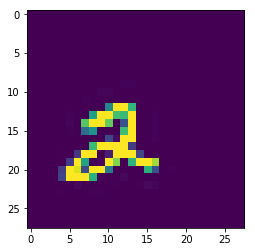

In [62]:
image_trans2 = np.load('./Test_Data/MNIST/Translated/test_2_transform.npy')
from matplotlib import pyplot as plt
plt.imshow(image_trans2)
img2 = image_trans2.reshape(-1, 28, 28, 1)
yolo_pred = np.array([[0,0,0,0,0,0,0,0,0,0]])

In [55]:
y_pred, x_recon = model.predict([img2, yolo_pred])
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.00920871 0.10625044 0.7920608  0.04492979 0.05823192 0.04267697
  0.00512219 0.00673655 0.04440588 0.00606619]] 
 Number is  2


# Testing on Distorted images

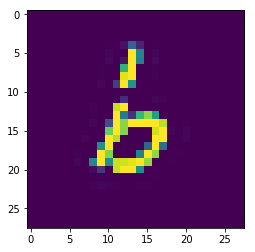

In [56]:
image_dist1 = np.load('./Test_Data/MNIST/Distorted/test_6_deform.npy')
from matplotlib import pyplot as plt
plt.imshow(image_dist1)
img1 = image_dist1.reshape(-1, 28, 28, 1)
yolo_pred = np.array([[0,0,0,0,0,0,0,0,0,0]])

In [57]:
y_pred, x_recon = model.predict([img1, yolo_pred])
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.04317833 0.02780077 0.42347935 0.01795128 0.04282872 0.08226176
  0.5831996  0.00163056 0.02706139 0.00254175]] 
 Number is  6


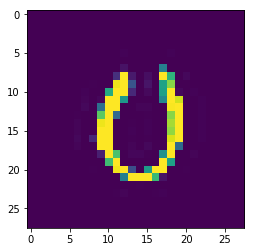

In [58]:
image_dist2 = np.load('./Test_Data/MNIST/Distorted/test_0_deform1.npy')
from matplotlib import pyplot as plt
plt.imshow(image_dist2)
img2 = image_dist2.reshape(-1, 28, 28, 1)
yolo_pred = np.array([[0,0,0,0,0,0,0,0,0,0]])

In [59]:
y_pred, x_recon = model.predict([img2, yolo_pred])
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.76932245 0.13233851 0.04201887 0.02087662 0.3768094  0.00647696
  0.15370429 0.01561271 0.03039536 0.05937099]] 
 Number is  0


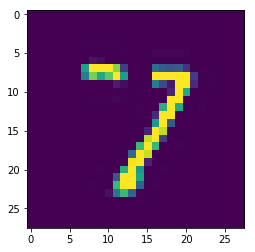

In [60]:
image_dist3 = np.load('./Test_Data/MNIST/Distorted/test_7_deform.npy')
from matplotlib import pyplot as plt
plt.imshow(image_dist3)
img3 = image_dist3.reshape(-1, 28, 28, 1)
yolo_pred = np.array([[0,0,0,0,0,0,0,0,0,0]])

In [61]:
y_pred, x_recon = model.predict([img3, yolo_pred])
print(y_pred,"\n","Number is ",np.argmax(y_pred[0]))

[[0.01798699 0.01321214 0.05188709 0.01295868 0.05613522 0.01067986
  0.02208034 0.95299226 0.11787902 0.01663105]] 
 Number is  7
